
***
## 5. Inference: how to extract a response from our model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/kulikov/vlgwork/ammi-2019-nlp/03-day/')
from seq2seq import seq2seq
from chat_dataset import TextDataset, batchify
import torch
from tqdm import tqdm

In [3]:
# now we put everything on gpu
train_dataset = TextDataset('../data/convai2_simple_train_wpersona_with_starts.txt', device='cuda')
valid_dataset = TextDataset('../data/convai2_simple_valid_wpersona_with_starts.txt', device='cuda', dictionary=train_dataset.shared_dict)

In [4]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=batchify, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, collate_fn=batchify, shuffle=False)

In [5]:
from seq2seq import seq2seq
model = seq2seq(train_dataset.get_vocab_size(), train_dataset.get_vocab_size(), embedding_size=300, dropout=0.3, grad_clip=0.1, hidden_size=512, use_cuda=True, encoder_attention='general', attention_time='pre', lr=0.0001, encoder_shared_lt=True) 

In [6]:
USE_PRETRAINED = True

if USE_PRETRAINED:
    model.load_model('512_pre_35.683342852656736.pt')

In [7]:
model

seq2seq(
  (decoder): DecoderRNN(
    (dropout): Dropout(p=0.3)
    (embedding): Embedding(18760, 300, padding_idx=0)
    (gru): GRU(300, 512, num_layers=2, batch_first=True, dropout=0.3)
    (attention): AttentionLayer(
      (linear_in): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=812, out_features=300, bias=False)
      (softmax): Softmax()
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=18760, bias=True)
  )
  (encoder): EncoderRNN(
    (dropout): Dropout(p=0.3)
    (embedding): Embedding(18760, 300, padding_idx=0)
    (gru): GRU(300, 512, num_layers=2, batch_first=True, dropout=0.3)
  )
  (criterion): CrossEntropyLoss()
)

In [8]:
valid_loader = DataLoader(valid_dataset, batch_size=1, collate_fn=batchify, shuffle=True)

# Inference: greedy search

### *On every timestep the token with maximum probability is selected.*

## $$\hat{y}_t = arg\max_{v \in V} \log p(y_t=v|\hat{y}_{<t}, Y_{<l}^s, Y_{<l}^{\bar{s}}, U).$$

- every token is selected from the whole vocabulary list

In [9]:
model.decode_greedy??

Signature: model.decode_greedy(encoder_states, batch_size)
Docstring: <no docstring>
Source:   
    def decode_greedy(self, encoder_states, batch_size):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        starts = self.sos_buffer.expand(batch_size, 1)  # expand to batch size
        decoder_hidden = encoder_hidden  # no attention yet

        # greedy decoding here        
        preds = [starts]
        scores = []
        
        finish_mask = torch.Tensor([0]*batch_size).byte().to(self.opts['device'])
        xs = starts
        _attn_w_log = []
        
        for ts in range(self.longest_label):
            decoder_output, decoder_hidden, attn_w_log = self.decoder(xs, decoder_hidden, encoder_states)
            _scores, _preds = F.log_softmax(decoder_output, dim=-1).max(dim=-1)
            preds.append(_preds)
            _attn_w_log.append(attn_w_log)
            scores.append(_scores.view(-1)*(finish_mask == 0).float())

            finish

# Greedy search: issues

### Greedy search is suboptimal especially in case of high-entropy output distributions trained with a maximum likelihood approach

## *discuss* --> why is it suboptimal? any particular example?

In [14]:
for i, batch in enumerate(valid_loader):
    out_greedy, dump = model.eval_step(batch, decoding_strategy='greedy', dump=True)
    print('input: {} \n\n\t g {:.{prec}f}: {} \n\n'.format(train_dataset.v2t(batch.text_vecs[0].tolist()),out_greedy[0][1], train_dataset.pred2text(out_greedy[0][0]),  prec=3))
    print()
    if i == 20:
        break

input: my family does not support my career choices . my dream car is a rolls <unk> ghost . i often shop for shoes and watches . i like shopping . i currently work for a watch dealer . hi there how are you doing ? <sep> hi . i ' m not doing well . my family does not support my choice of career . <sep> really why is that ? mine doesn ' t get me for being a vegetarian <sep> i want to work for a watch dealer and i like to shop for watches and shoes . <sep> well if that ' s what makes you happy go for it 

	 g -12.647: <sos> i ' m a bit of a loner . i ' m a bit of a loner . 



input: i ' m a boy . i can move objects with my mind . i had to have a transplant . i was born with my heart outside my body . hi ! i have taken a break from my knitting to chat ! how are you ? <sep> i am good and you , are you male or female ? <sep> i am female , of course ! i am on the internet , am i not ? <sep> what kind of job do you have ? <sep> i ' m retired but i love baking cookies for the bake sale . you ?

# Beam search

![beampic](nbimgs/ironbeam.jpeg)

Beam search is a term appeared in 1977 from CMU. It stands for a heuristic search algorithm in graphs. The main idea of a beam search: at each level of a tree it generates all successors of the states at the current level, sorting them in increasing order of heuristic cost but let only top-K best successors to continue.

## Mathematical formulation

Instead of maintaining a single hypothesis at a time, as in greedy search above, beam search maintains $K$ hypotheses:

## $$\mathcal{H}_t = \{ (y_1^1, \dots, y_t^1), \dots, (y_1^K, \dots, y_t^K) \}$$

Each hypothesis is expanded with all possible next tokens $v$ to form candidate hypotheses, each of which is in the form of

## $$\tilde{h}^i_v = (y_1^i, \ldots, y_t^i, v),$$

where $v \in V$. Each candidate is associated with its score:

## $$s(\tilde{h}^i_v) = \sum_{t'=1}^t \log p ( y_{t'}^i | y_{<t'}^i) + \log p(v|y_{\leq t}^i).$$

The new hypothesis set of $K$ hypotheses is then constructed as

## $$\mathcal{H}_{t+1} = \underset{i,v}{\text{arg-top-}k}~~ s(\tilde{h}^i_v).$$

When all the hypotheses in the new hypothesis set have terminated, i.e., $y_{t+1}^i=\left<\text{eos}\right>$ for all $i$, beam search terminates, and the hypothesis with the highest score is returned.
    


## Technical details and implementation: ~IMPORTANT~

In [9]:
from beam import Beam
Beam.__init__??

Signature: Beam.__init__(self, beam_size=10, min_length=3, padding_token=0, bos_token=2, eos_token=3, min_n_best=3, device='cpu', block_ngram=1, expand_beam=1)
Docstring: Initialize self.  See help(type(self)) for accurate signature.
Source:   
    def __init__(
        self,
        beam_size=10,
        min_length=3,
        padding_token=PAD_IDX,
        bos_token=SOS_IDX,
        eos_token=EOS_IDX,
        min_n_best=3,
        device="cpu",
        block_ngram=1,
        expand_beam=1,
    ):
        self.beam_size = beam_size
        self.min_length = min_length
        self.min_n_best = min_n_best
        self.eos = eos_token
        self.bos = bos_token
        self.pad = padding_token
        self.device = device

        self.scores = torch.Tensor(self.beam_size).float().zero_().to(self.device)
        self.all_scores = [torch.Tensor([0.0] * beam_size).to(self.device)]
        self.bookkeep = []
        self.outputs = [
            torch.Tensor(self.beam_size).long().fill_(se

assume `beam_size = 5`

`self.outputs = [ [1,1,1,1,1] ]`

`self.scores = [0,0,0,0,0]`

`HypothesisTail = ("timestep", "hypid", "score", "tokenid")`

In [11]:
model.decode_beam??

Signature: model.decode_beam(beam_size, batch_size, encoder_states, block_ngram=0, expand_beam=1)
Docstring: <no docstring>
Source:   
    def decode_beam(self, beam_size, batch_size, encoder_states, block_ngram=0, expand_beam=1):
        dev = self.opts['device']
        beams = [ Beam(beam_size, device='cuda', block_ngram=block_ngram, expand_beam=expand_beam) for _ in range(batch_size) ]
        decoder_input = self.sos_buffer.expand(batch_size * beam_size, 1).to(dev)
        inds = torch.arange(batch_size).to(dev).unsqueeze(1).repeat(1, beam_size).view(-1)
        
        encoder_states = self.reorder_encoder_states(encoder_states, inds)  # not reordering but expanding
        incr_state = encoder_states[1]
        
        for ts in range(self.longest_label):
            if all((b.done() for b in beams)):
                break
            score, incr_state, attn_w_log = self.decoder(decoder_input, incr_state, encoder_states)
            score = score[:, -1:, :]
            score =

# Main beam routines happen in advance function

In [10]:
Beam.advance??

Signature: Beam.advance(self, softmax_probs)
Docstring: <no docstring>
Source:   
    def advance(self, softmax_probs):
        voc_size = softmax_probs.size(-1)
        current_length = len(self.all_scores) - 1
        if current_length < self.min_length:
            # penalize all eos probs to make it decode longer
            for hyp_id in range(softmax_probs.size(0)):
                softmax_probs[hyp_id][self.eos] = -NEAR_INF

        if len(self.bookkeep) == 0:
            # the first step we take only the first hypo into account since all
            # hypos are the same initially
            beam_scores = softmax_probs[0]
        else:
            beam_scores = softmax_probs + self.scores.unsqueeze(1).expand_as(
                softmax_probs
            )

        for i in range(self.outputs[-1].size(0)):
            if self.do_block_ngram(i, self.block_ngram):
                beam_scores[i] = -NEAR_INF

        flatten_beam_scores = beam_scores.view(-1)  # [beam_size * voc_siz

### There are many places where bugs can occur on the way. Visualization of the beam tree is an efficient way of checking that everything is fine. And we have it!

# Lets do some beam search!

In [19]:
import graphviz

In [12]:
valid_loader = DataLoader(valid_dataset, batch_size=2, collate_fn=batchify, shuffle=True)

def show_beam_tree(beam_obj, n_best, dataset):
    return graphviz.Source(beam_obj.get_beam_dot(dictionary=dataset, n_best=n_best))

beam_size = 5
block_ngram = 1
expand_beam = 10

for i, batch in enumerate(valid_loader):
    out_beam, beam = model.eval_step(batch, decoding_strategy='beam:{}:{}:{}'.format(beam_size, block_ngram, expand_beam))
    print('b {}, {:.{prec}f} {}'.format(beam_size, out_beam[0][1],train_dataset.pred2text(out_beam[0][0]),  prec=3))
    out_greedy, dump = model.eval_step(batch, decoding_strategy='greedy', dump=True)
    print('g {:.{prec}f}: {}'.format(out_greedy[0][1], train_dataset.pred2text(out_greedy[0][0]),  prec=3))
    print()
    
    #import ipdb; ipdb.set_trace()
    if i == 10:
        break

b 5, -4.199 <sos> what do you do for a living ?
g -13.344: <sos> i ' m sure it is . i ' m sure you are a good listener .

b 5, -6.400 <sos> i ' m sorry to hear that . what do you do for fun ?
g -15.176: <sos> i ' m sure you are a little taller . i ' m sure you are a good listener .

b 5, -5.531 <sos> i ' m sorry to hear that . what do you do for a living ?
g -13.333: <sos> i ' ve a dog , he ' s a handful . i ' m a vet

b 5, -5.901 <sos> that sounds like a lot of fun
g -11.202: <sos> that ' s cool . i ' m a teacher , i ' m a teacher

b 5, -5.303 <sos> i ' m a stay at home mom
g -5.931: <sos> i work at a grocery store

b 5, -6.344 <sos> thank you for your service . what do you do for fun ?
g -8.593: <sos> thank you . i ' m glad you are having a good day

b 5, -5.988 <sos> i work at a grocery store
g -5.988: <sos> i work at a grocery store

b 5, -5.504 <sos> that ' s cool , what do you do for a living ?
g -12.463: <sos> i like to read , i ' m a huge fan of music

b 5, -9.261 <sos> i ' d l

## Checking the processed Beam sctructures

In [14]:
beam[0].outputs

[tensor([2, 2, 2, 2, 2], device='cuda:0'),
 tensor([  5,  16, 137, 207,  55], device='cuda:0'),
 tensor([ 28,  46, 117,   6,  19], device='cuda:0'),
 tensor([29, 14, 37, 55,  7], device='cuda:0'),
 tensor([ 14,  55,  37, 180, 125], device='cuda:0'),
 tensor([724, 137,  14, 158, 401], device='cuda:0'),
 tensor([ 10, 212,  78,   5,  22], device='cuda:0'),
 tensor([   5,   78,    5,  204, 4113], device='cuda:0'),
 tensor([28, 44, 46, 10, 32], device='cuda:0'),
 tensor([ 29,  25,   5, 310,  14], device='cuda:0'),
 tensor([ 32,   6, 125,  14,  28], device='cuda:0'),
 tensor([48, 27,  7, 29, 37], device='cuda:0'),
 tensor([  3,  14, 103, 175,  32], device='cuda:0'),
 tensor([134,  27,  27,  27,  19], device='cuda:0'),
 tensor([27,  3,  3,  3, 16], device='cuda:0')]

In [15]:
beam[0].bookkeep

[tensor([0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 3], device='cuda:0'),
 tensor([0, 1, 1, 1, 3], device='cuda:0'),
 tensor([0, 0, 0, 0, 0], device='cuda:0'),
 tensor([1, 2, 1, 1, 0], device='cuda:0'),
 tensor([0, 2, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 2, 1, 1], device='cuda:0'),
 tensor([0, 3, 0, 4, 1], device='cuda:0'),
 tensor([0, 4, 3, 0, 2], device='cuda:0'),
 tensor([1, 1, 0, 0, 2], device='cuda:0'),
 tensor([0, 0, 1, 4, 0], device='cuda:0'),
 tensor([1, 0, 0, 0, 2], device='cuda:0'),
 tensor([1, 2, 3, 4, 0], device='cuda:0'),
 tensor([0, 1, 2, 3, 4], device='cuda:0')]

In [16]:
beam[0].all_scores

[tensor([0., 0., 0., 0., 0.], device='cuda:0'),
 tensor([-0.6604, -2.5956, -3.7149, -3.9993, -4.2105], device='cuda:0',
        grad_fn=<TopkBackward>),
 tensor([-1.9370, -2.0962, -3.2366, -3.2736, -4.0936], device='cuda:0',
        grad_fn=<TopkBackward>),
 tensor([-2.0224, -3.7306, -4.2578, -4.4636, -4.4766], device='cuda:0',
        grad_fn=<TopkBackward>),
 tensor([-3.8202, -4.2312, -4.4593, -5.1897, -5.2803], device='cuda:0',
        grad_fn=<TopkBackward>),
 tensor([-5.5833, -5.9806, -6.0499, -6.7602, -6.7752], device='cuda:0',
        grad_fn=<TopkBackward>),
 tensor([-6.4742, -7.5884, -7.6314, -7.8901, -8.0638], device='cuda:0',
        grad_fn=<TopkBackward>),
 tensor([-7.1722, -8.6236, -8.7250, -8.7913, -8.8046], device='cuda:0',
        grad_fn=<TopkBackward>),
 tensor([-8.9921, -9.1380, -9.1898, -9.2264, -9.3704], device='cuda:0',
        grad_fn=<TopkBackward>),
 tensor([ -9.2188,  -9.3762,  -9.9087, -11.1272, -11.1652], device='cuda:0',
        grad_fn=<TopkBackward>),
 t

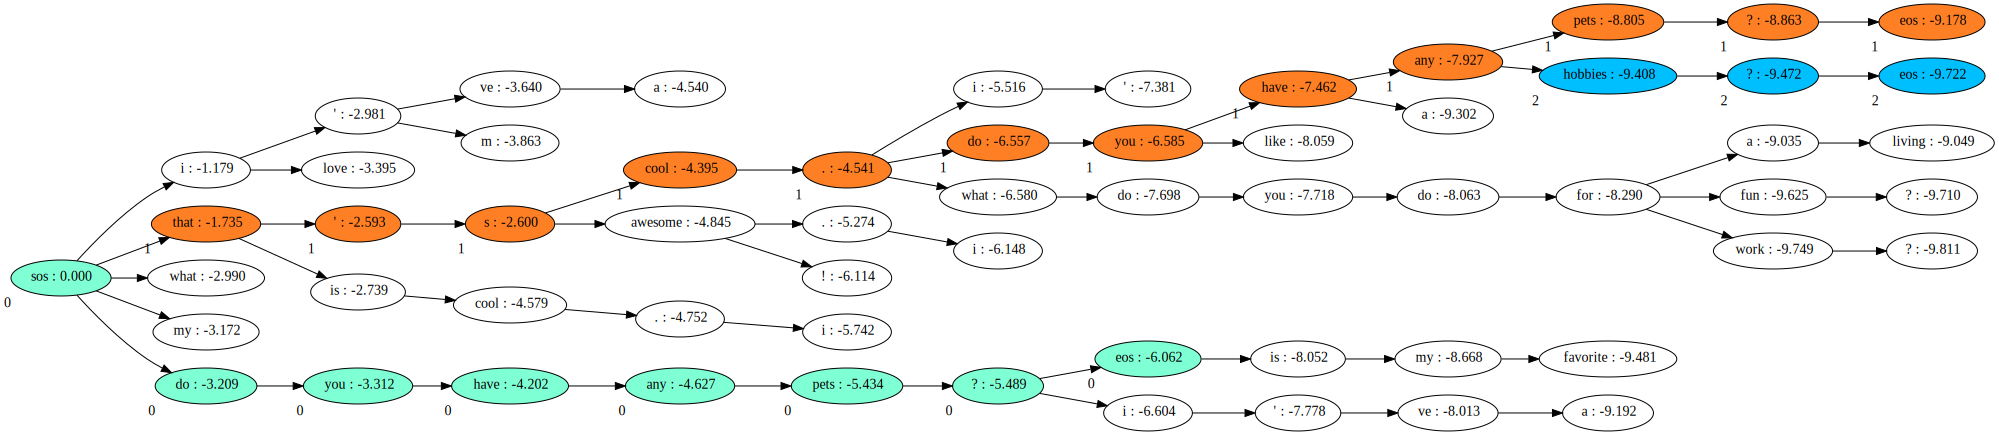

In [20]:
show_beam_tree(beam[1], 3, train_dataset)

## *discuss* <-- what can we say about that tree? 

# Important heuristics: repetetive ngram blocking

In [21]:
Beam.do_block_ngram??

Signature: Beam.do_block_ngram(self, i, n)
Docstring: <no docstring>
Source:   
    def do_block_ngram(self, i, n):
        if n > 0:
            for n_gram in range(2, n + 1):
                current_hypo = self.partial_hyps[i, 1:]
                ngrams = set()
                gram = []
                for l in range(len(current_hypo)):
                    gram = (gram + [current_hypo[l].item()])[-n_gram:]
                    if tuple(gram) in ngrams:
                        return True
                    else:
                        ngrams.add(tuple(gram))
        return False
File:      /misc/vlgscratch4/ChoGroup/kulikov/ammi-2019-nlp/03-day/beam.py
Type:      function


# Important heuristics: length penalty

In [70]:
Beam.get_length_penalty??

Signature: Beam.get_length_penalty(length)
Docstring: <no docstring>
Source:   
    @staticmethod
    def get_length_penalty(length):
        return math.pow((1 + length) / 6, 0.65)
File:      /misc/vlgscratch4/ChoGroup/kulikov/ammi-2019-nlp/03-day/beam.py
Type:      function


# Important heuristics: expanding the beam during the selection. ref: [pdf](https://pdfs.semanticscholar.org/febf/7c3b532ceb029fe17a0e1c43ec84c308a781.pdf)

In [74]:
valid_loader = DataLoader(valid_dataset, batch_size=2, collate_fn=batchify, shuffle=True)

beam_size = 10
block_ngram = 5
expand_beam = 20

for i, batch in enumerate(valid_loader):
    out_beam_expanded, beam_expanded = model.eval_step(batch, decoding_strategy='beam:{}:{}:{}'.format(beam_size, block_ngram, expand_beam))
    print('b expanded {}, {:.{prec}f} {}'.format(beam_size, out_beam_expanded[0][1],train_dataset.pred2text(out_beam_expanded[0][0]),  prec=3))
    
    out_beam, beam = model.eval_step(batch, decoding_strategy='beam:{}:{}:{}'.format(beam_size, block_ngram, 1))
    print('b {}, {:.{prec}f} {}'.format(beam_size, out_beam[0][1],train_dataset.pred2text(out_beam[0][0]),  prec=3))
    
    print()
    if i == 10:
        break

b expanded 10, -5.038 <sos> do you have any hobbies ?
b 10, -5.038 <sos> do you have any hobbies ?

b expanded 10, -5.518 <sos> what kind of music do you like ?
b 10, -5.714 <sos> do you have any hobbies ?

b expanded 10, -3.441 <sos> what do you do for a living ?
b 10, -3.441 <sos> what do you do for a living ?

b expanded 10, -10.949 <sos> a little bit of a rock band . i love it !
b 10, -6.713 <sos> i don ' t have any pets . what do you do for a living ?

b expanded 10, -7.020 <sos> yes . do you have any pets ?
b 10, -5.475 <sos> no , i do not . do you ?

b expanded 10, -4.342 <sos> i am doing well . how are you ?
b 10, -4.342 <sos> i am doing well . how are you ?

b expanded 10, -5.111 <sos> i ' m sorry to hear that .
b 10, -5.111 <sos> i ' m sorry to hear that .

b expanded 10, -4.145 <sos> what do you do for a living ?
b 10, -5.309 <sos> yes it is . what do you do for a living ?

b expanded 10, -5.600 <sos> cool . what do you do for a living ?
b 10, -5.538 <sos> that ' s cool . wh

# simple beam

In [76]:
min_n_best=5
n_best_beams = [b.get_rescored_finished(n_best=min_n_best) for b in beam]
n_best_beam_preds_scores = []
for i, beamhyp in enumerate(n_best_beams):
    this_beam = []
    for hyp in beamhyp:
        pred = beam[i].get_pretty_hypothesis(
            beam[i].get_hyp_from_finished(hyp))
        score = hyp.score
        this_beam.append((pred, score))
    n_best_beam_preds_scores.append(this_beam)

for pred, score in n_best_beam_preds_scores[0]:
    print(train_dataset.pred2text(pred))

<sos> what do you do for a living ?
<sos> do you have any pets ?
<sos> what do you do for fun ?
<sos> what do you do for work ?
<sos> do you have any hobbies ?


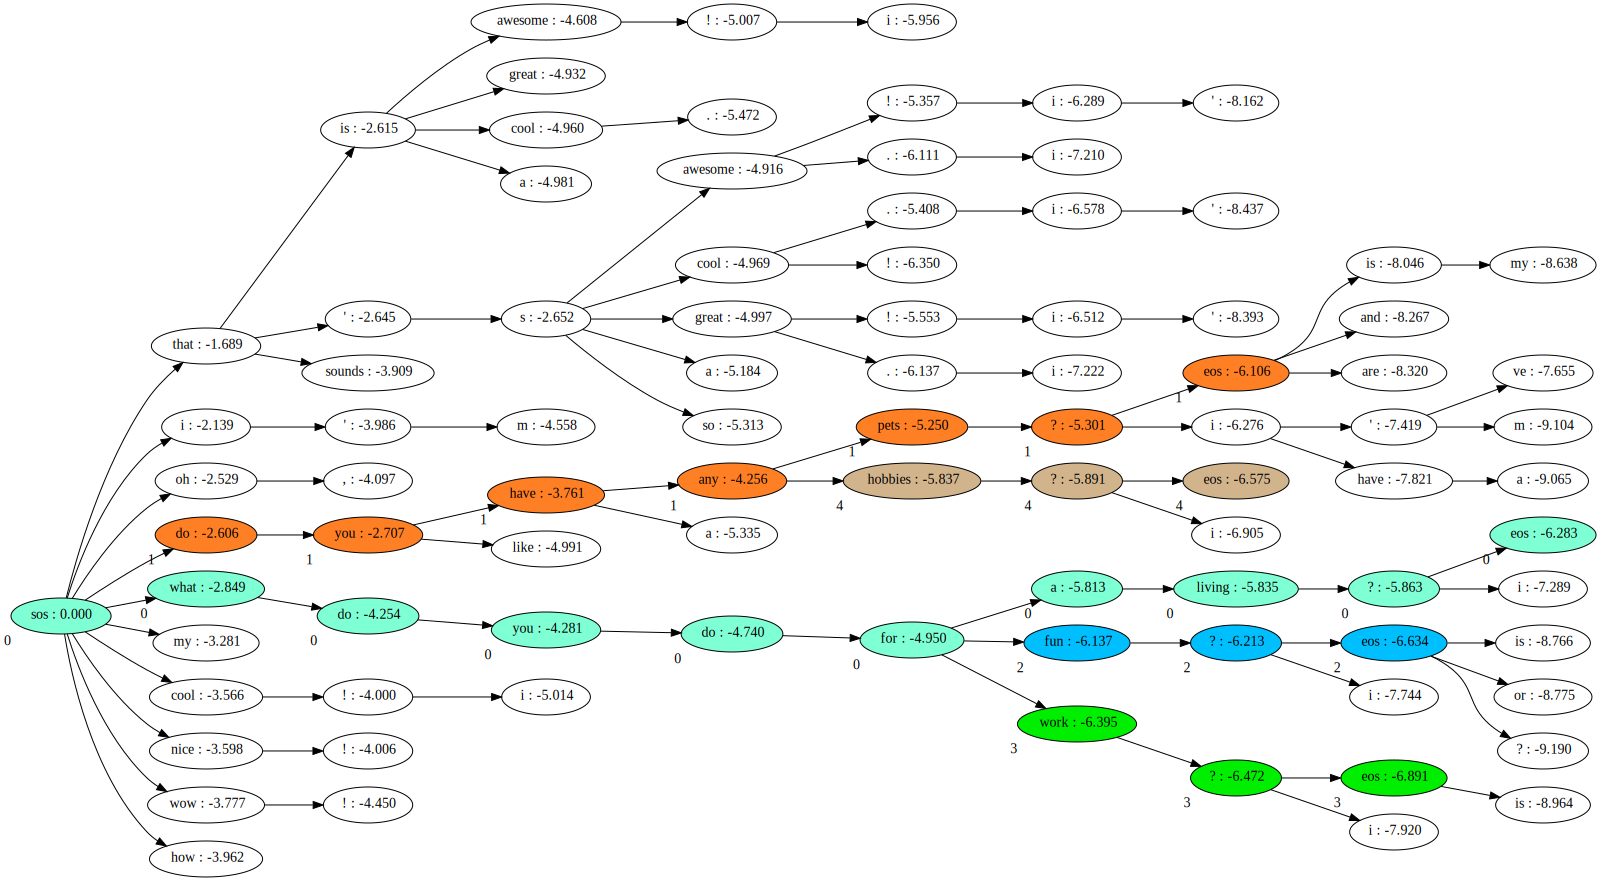

In [79]:
show_beam_tree(beam[0], 5, train_dataset)

# expanded beam

In [77]:
min_n_best=5
n_best_beams = [b.get_rescored_finished(n_best=min_n_best) for b in beam_expanded]
n_best_beam_preds_scores = []
for i, beamhyp in enumerate(n_best_beams):
    this_beam = []
    for hyp in beamhyp:
        pred = beam_expanded[i].get_pretty_hypothesis(
            beam_expanded[i].get_hyp_from_finished(hyp))
        score = hyp.score
        this_beam.append((pred, score))
    n_best_beam_preds_scores.append(this_beam)

for pred, score in n_best_beam_preds_scores[0]:
    print(train_dataset.pred2text(pred))

<sos> do you have any pets ?
<sos> what do they like to do for fun ?
<sos> nice . do you like to travel ?
<sos> oh , that is a lot of kids !


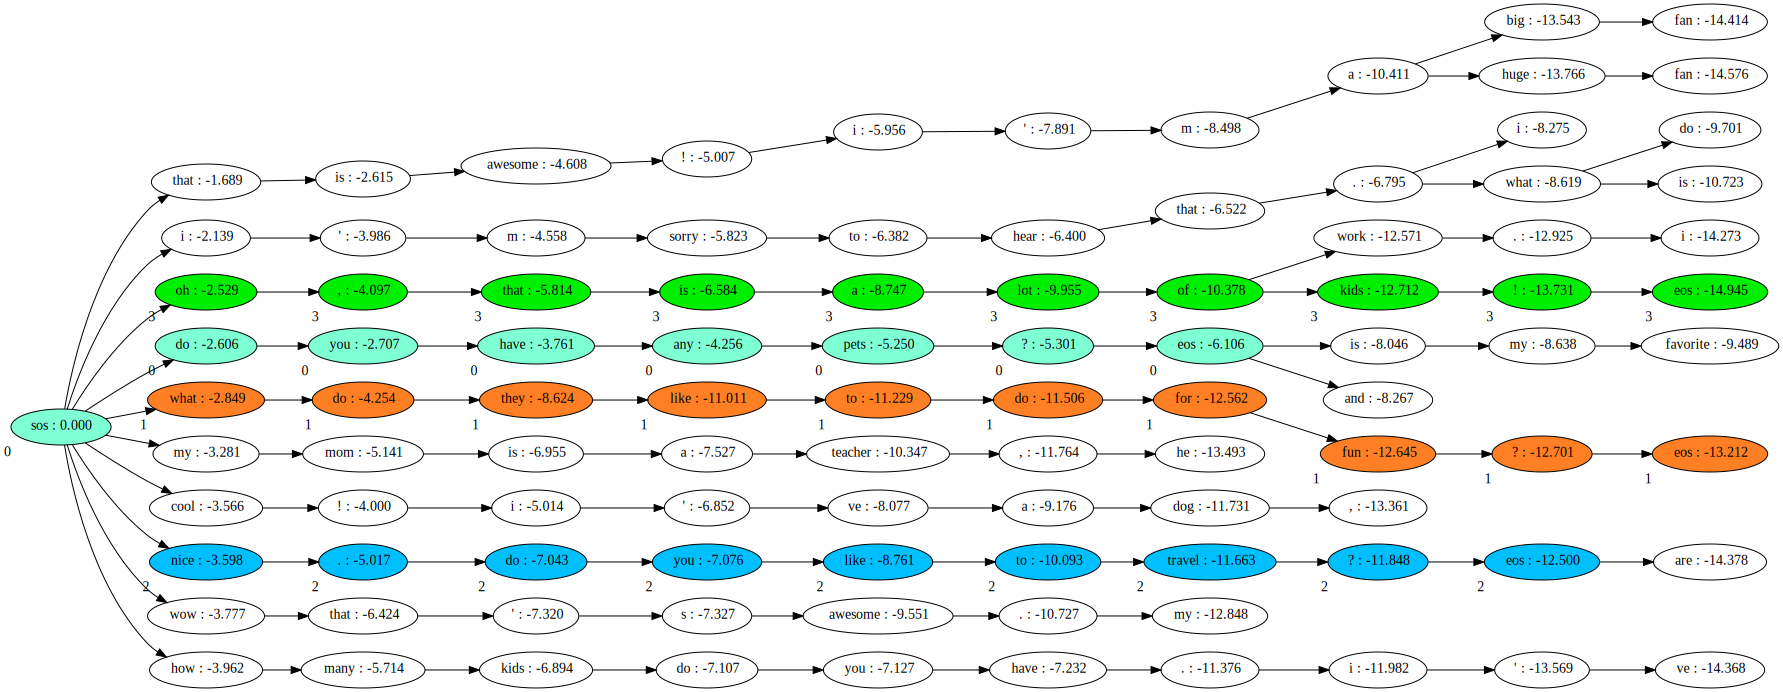

In [78]:
show_beam_tree(beam_expanded[0], 5, train_dataset)

# LETS CHAT

In [82]:
import re
from chat_dataset import Batch

def start_chat(model, context, train_dataset, use_cuda=True):
    RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)
    
    device = 'cuda' if use_cuda else 'cpu'
    user_input = ''
    history = train_dataset.t2v(RETOK.findall(context))
    while user_input != 'exit':
        user_input = input()
        user_input = user_input.lower()
        history.extend([train_dataset.word2ind['<sep>']] + train_dataset.t2v(RETOK.findall(user_input)))
        batch = Batch(text_vecs=torch.Tensor([history]).long().to(device), text_lens=[len(history)], label_vecs=None, label_lens=None, use_packed=False)
        beam_pred_scores, beam = model.eval_step(batch, decoding_strategy='beam:5:5:10')
        print(train_dataset.pred2text(beam_pred_scores[0][0]))
        history.extend([train_dataset.word2ind['<sep>']] + beam_pred_scores[0][0].tolist()[1:-1])
        #print('history: {}'.format(train_dataset.v2t(history)))

In [83]:
model_persona = 'i live in nyc. i am russian. i like riding bicycle. my hobby is judo.'

start_chat(model, model_persona, train_dataset)

 hey!


<sos> what do you do for a living ?


 i am a student, what about you?


<sos> i am in school right now .


 where do you live?


<sos> new york city . how about you ?


 i am in africa right now!


<sos> what do you do for a living ?


 exit


<sos> what do you do for a living ?
